# Tester notebook for the LDA dimensionality reduction method

In [3]:
# Imports

#Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Scikit Learn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

/Users/chris/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
# Load data
trainDataNP = np.load("fashion_train.npy")
testDataNP = np.load("fashion_test.npy")

# Split data into X and y arrays
X_train = trainDataNP[:, :-1]
y_train = trainDataNP[:, -1]
X_test = testDataNP[:, :-1]
y_test = testDataNP[:, -1]

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [5]:
# Create LDA class

class LDA:
    def __init__(self):
        pass

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        self.class_labels = np.unique(y_train)
        self.coeffs, self.constants = self.compute_coeffs_and_constants()
        return self

    def compute_class_stats(self, class_label):
        '''Compute class specific statistics.'''
        class_data = self.X_train[self.y_train == class_label]
        class_sample_mean = np.mean(class_data, axis = 0)
        class_sample_var = np.var(class_data, axis = 0)
        class_sample_prior = np.sum(self.y_train == class_label) / len(self.y_train)
        return class_sample_mean, class_sample_var, class_sample_prior

    def compute_coeffs_and_constants(self):
        '''Compute coefficients and constants for each class.'''
        coeffs = {} # Initialize empty dictionary for coefficients
        constants = {} # Initialize empty dictionary for constants
        epsilon = 1e-12 # Small constant to avoid division by zero

        # Iterate over each class
        for class_label in self.class_labels:

            # Get statistics for class
            sample_mean, sample_var, sample_prior = self.compute_class_stats(class_label)
            
            # Compute coefficient
            alpha = sample_mean / (sample_var + epsilon)

            # Compute constant
            beta = -(np.sum(sample_mean**2) / (2 * np.sum(sample_var))) + np.log(sample_prior)

            # Record coefficient and constant in dictionaries
            coeffs[class_label] = alpha
            constants[class_label] = beta

        return coeffs, constants

    def discriminant(self, X, alpha, beta):
        '''Compute the discriminant value for an input value or array X.'''
        return np.dot(X, alpha) + beta

    def predict(self, X):
        '''Predict class for an input value or array X.'''
        # check_is_fitted(self)
        # X = check_array(X)

        # Compute the discriminant values for each label
        discriminants = np.array([self.discriminant(X, self.coeffs[class_label], self.constants[class_label]) for class_label in self.class_labels])
        
        # Predict classes and add labels
        predicted_labels = np.argmax(discriminants, axis = 0)
        predicted_classes = np.array(self.class_labels)[predicted_labels]
        
        return predicted_classes

    def transform(self, X, n_components):
        '''Project data onto the linear discriminant space.'''
        # check_is_fitted(self)
        # X = check_array(X)

        # Initialize empty array to store projected data
        projected_data = np.zeros((len(X), len(self.class_labels)))

        # Iterate over each class
        for idx, class_label in enumerate(self.class_labels):
            # Project data using the pre-computed coefficients and constants
            # projected_data[:, idx] = np.dot(X, self.coeffs[class_label]) + self.constants[class_label]

            # Compute the discriminant values
            discriminants = self.discriminant(X, self.coeffs[class_label], self.constants[class_label])

            # Project data using the discriminant value
            projected_data[:, idx] = discriminant

        return projected_data[:, :n_components]

    def score(self, X, y):
        '''Compute accuracy for the given input data and labels.'''
        # check_is_fitted(self)
        # X = check_array(X)
        # y = check_array(y)
        y_pred = self.predict(X)
        accuracy = np.mean(y_pred == y)
        return accuracy

In [6]:
# Check accuracy

# Initialize LDA model
lda_model = LDA()
lda_model.fit(X_train_scaled, y_train)

accuracy = lda_model.score(X_test_scaled, y_test)
print(accuracy)

0.205


Very low..

In [14]:
# Create new Multiple Discriminant Analysis (MDA) class which maybe works better
# Code is adapted using 
# Alpaydin, E. (2014). Introduction to Machine Learning. The MIT Press. Section 6.8
# and
# https://www.csd.uwo.ca/~oveksler/Courses/CS434a_541a/Lecture8.pdf?fbclid=IwAR2txae5XGTwi8Gjo2y9SbwguiJ0SUbLvCBzY0rYq-HOxhfr2MAjPo1GG3A

class MDA:
    def __init__(self, k = 2):
        self.k = k # Amount of discriminant variables
        
    def fit_transform(self, X, y):

        class_labels = np.unique(y)
        m = X.shape[1] # Amount of features

        # Compute total mean of all samples
        mu = np.mean(X, axis = 0).reshape(m, 1) # Reshape to be vertical vector

        # Initiate within- and between-class scatter matrices as empty
        S_W = np.zeros((m, m))
        S_B = np.zeros((m, m))

        # Compute within- and between-class scatter matrices by iterating over each class i
        for label in class_labels:

            X_i = X[y == label] # Matrix of data points for class i
            mu_i = np.mean(X_i, axis = 0).reshape(m, 1) # Sample mean of class i

            # Initiate withing scatter matrix for class i as empty
            S_i = np.zeros((m, m))
            for row in X_i:
                row = row.reshape(m, 1) # Reshape row to be vertical vector
                S_i += np.dot(row - mu_i, (row - mu_i).T)

            # Add scatter matrix of class i to within-class scatter matrix
            S_W += S_i

            # Update between-class scatter matrix using amount of samples, as well as class and total means
            n_i = X_i.shape[0] # Amount of samples in class i
            S_B += n_i * np.dot(mu_i - mu, (mu_i - mu).T)

        # Compute the inverse of the within-class scatter matrix
        S_W_inv = np.linalg.inv(S_W)

        # Solve the generalized eigenvalue problem
        eigenvalues, eigenvectors = np.linalg.eig(np.dot(S_W_inv, S_B))
        
        # Sort the eigenvalues and eigenvectors in descending order
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:, sorted_indices]

        # Select the top k eigenvectors
        selected_eigenvectors = eigenvectors[:, :self.k]

        # Make sure numbers in eigenvectors are not complex
        selected_eigenvectors = np.real(selected_eigenvectors)

        # Normalize eigenvectors
        normalized_eigenvectors = selected_eigenvectors / np.linalg.norm(selected_eigenvectors, axis = 0)

        # Project the data onto the normalized discriminant subspace
        X_projected = np.dot(X, normalized_eigenvectors)

        return X_projected

In [15]:
mda = MDA()
X_projected = mda.fit_transform(X_train_scaled, y_train)

In [16]:
X_projected

array([[-1.23149779,  0.21399632],
       [ 2.49507967, -0.40452641],
       [-0.93425513,  0.1879579 ],
       ...,
       [-0.10597058,  1.34595721],
       [-0.68637265,  0.34283279],
       [ 3.01065924, -0.27911939]])

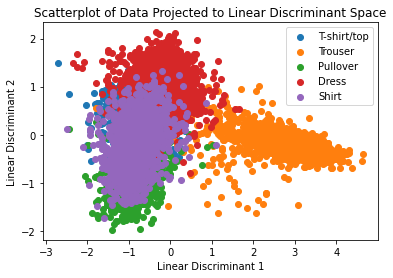

In [18]:
class_labels = np.unique(y_train)

label_names = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Shirt"
}

# Create a scatter plot
for idx, class_label in enumerate(class_labels):
    class_data = X_projected[y_train == class_label]
    fig = plt.scatter(class_data[:, 0], class_data[:, 1], label=label_names[class_label])

plt.xlabel('Linear Discriminant 1')
plt.ylabel('Linear Discriminant 2')
plt.title('Scatterplot of Data Projected to Linear Discriminant Space')
plt.legend()
plt.show()

In [12]:
sklearn_MDA = LinearDiscriminantAnalysis(n_components = 2)
sklearn_MDA.fit(X_train, y_train)
sklearn_projected = sklearn_MDA.transform(X_train)
sklearn_projected

array([[-2.56669806, -0.55699892],
       [ 5.20026605,  1.0529189 ],
       [-1.9471824 , -0.48922497],
       ...,
       [-0.22086478, -3.5033158 ],
       [-1.43054366, -0.89234007],
       [ 6.27484131,  0.72650406]])

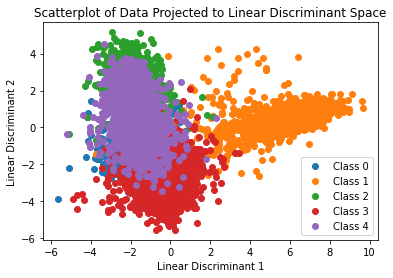

In [13]:
# Create a scatter plot
for idx, class_label in enumerate(class_labels):
    class_data = sklearn_projected[y_train == class_label]
    plt.scatter(class_data[:, 0], class_data[:, 1], label=f'Class {class_label}')

plt.xlabel('Linear Discriminant 1')
plt.ylabel('Linear Discriminant 2')
plt.title('Scatterplot of Data Projected to Linear Discriminant Space')
plt.legend()
plt.show()

In [14]:
arr1 = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

for row in arr1:
    print((row - np.array([.5, .5, .5])).T)
    print('\n')

[0.5 1.5 2.5]


[3.5 4.5 5.5]


[6.5 7.5 8.5]




In [15]:
X_1 = X_projected[:, 0]
X_2 = X_projected[:, 1]

print(X_1)

[-1.23149779  2.49507967 -0.93425513 ... -0.10597058 -0.68637265
  3.01065924]


In [16]:
def kernel_estimate(data, x, h):
    n = len(data)
    count = 0
    for data_point in data:
        if data_point >= x - h and data_point <= x + h:
            count += 1
    return count / (n * 2 * h)

In [17]:
x_range = np.linspace(-3, 5, 1000)
h = .5

X_1_estimates = []
X_2_estimates = []
for x in x_range:
    X_1_estimates.append(kernel_estimate(X_1, x, h))
    X_2_estimates.append(kernel_estimate(X_2, x, h))

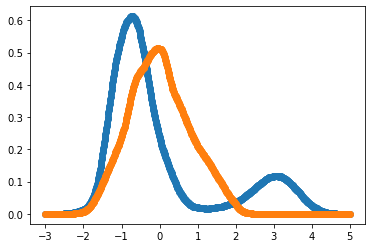

In [18]:
import matplotlib.pyplot as plt

plt.scatter(x_range, X_1_estimates)
plt.scatter(x_range, X_2_estimates)

In [77]:
# class bayes_nonparametric:
#     def __init__(self, X_train, y_train, x_range, h):
#         # self.X_1 = X_1
#         # self.X_2 = X_2
#         self.X_train = X_train
#         self.class_labels = np.unique(y_train)
#         self.class_priors = {cl: len(X_train[y_train == cl])/len(X_train) for cl in self.class_labels}
#         # self.x_range = x_range
#         self.h = h

#     def kernel_density_estimate(self, X, x):
#         '''Estimate f(x) for a single input value x.'''
#         n = len(X)
#         kernel_sum = sum(1 for dp in X if dp >= x - self.h and dp <= x + self.h)
#         return kernel_sum / (n * 2 * self.h)
    
#     def likelihood_kde(self, X):


#     def predict(self, x):
#         '''Predict class for input value or array x.'''
#         prediction = np.array([int(self.kernel_estimate(self.X_1, x_i) <= self.kernel_estimate(self.X_1, x_i)) for x_i in x])
#         return prediction

#     def plot_decision_regions(self):

#         # Define a custom colormap for the labels
#         custom_cmap = ListedColormap(['red', 'blue'])

#         # Define a grid of points for the decision region plot
#         x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
#         y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
#         xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

#         # Predict the class labels for each point in the grid
#         Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
#         Z = Z.reshape(xx.shape)

#         # Create a contour plot of the decision boundaries using the custom colormap
#         plt.contourf(xx, yy, Z, cmap = custom_cmap, alpha = .6)

#         # Scatter plot of the data points using the same custom colormap
#         plt.scatter(X_train[:, 0], X_train[:, 1], c = y_train, cmap = custom_cmap, edgecolor = 'k')
#         plt.xlabel('x1')
#         plt.ylabel('x2')
#         plt.title('Multinomial Logistic Regression Decision Boundaries')
#         plt.show()

In [ ]:
class bayes_nonparametric:
    def __init__(self):
        # self.X_train = X_train
        # self.y_train = y_train
        # self.classes = np.unique(y_train)
        # self.priors = None
        # self.feature_distributions = {}
        pass

    def calculate_class_priors(self, y_train):
        class_counts = {cl: np.sum(y_train == cl) for cl in self.classes}
        n_samples = len(y_train)
        self.priors = {cl: count/n_samples for cl, count in class_counts.items()}

    def train(self, X_train, y_train):
        self.classes = np.unique(y_train)
        self.calculate_class_priors(y_train)

        

-3.0 -0.36536536536536524


ValueError: operands could not be broadcast together with shapes (2,) (1000,) 

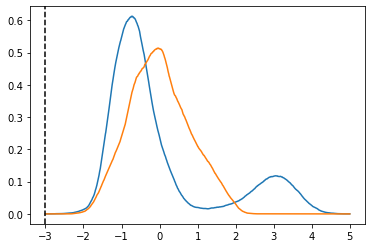

In [76]:
bayes = bayes_nonparametric(X_1, X_2, x_range, h)
bayes.plot_decision_regions()

In [ ]:
    ## FIX THIS BELOW, NEED TO HAVE MULTIPLE DECISION BOUNDARIES !!!

    # def get_decision_boundary(self):
        # sign_change_indices = np.where(np.diff(np.sign(self.X_1 - self.X_2)))[0]
        # if sign_change_indices.size > 0:
        #     decision_boundary = self.x_range[sign_change_indices[0]]
        # else:
        #     # No sign change found, one function dominates the other on all ranges of x
        #     if self.X_1[0] > self.X_2[0]:
        #         decision_boundary = -np.inf
        #     else:
        #         decision_boundary = np.inf

        # return decision_boundary

    ## FIX THIS BELOW

    # def plot_decision_regions(self):

    #     # Get estimates
    #     X_1_pdf = [self.kernel_estimate(X_1, x) for x in self.x_range]
    #     X_2_pdf = [self.kernel_estimate(X_2, x) for x in self.x_range]

    #     # Plot the likelihood functions g_k(x)
    #     plt.plot(self.x_range, X_1_pdf, label = 'f_1(x)')
    #     plt.plot(self.x_range, X_2_pdf, label = 'f_2(x)')

    #     # Find the decision boundary (where X_1 = X_2, if any)
    #     decision_boundary = self.get_decision_boundary()
    #     plt.axvline(x = decision_boundary, color = 'k', linestyle = '--', label = 'Decision Boundary')

    #     # Highlight the decision regions
    #     plt.fill_between(self.x_range, X_1_pdf, where = (self.x_range > decision_boundary), alpha = .2, label = 'Decision Region for Y=1')
    #     plt.fill_between(self.x_range, X_2_pdf, where = (self.x_range <= decision_boundary), alpha = .2, label = 'Decision Region for Y=2')

    #     # Add labels and legend
    #     plt.xlabel('x')
    #     plt.ylabel('f(x)')
    #     plt.title('Bayes Classifier')
    #     plt.legend()
    #     plt.grid(True)

    #     # Show plot
    #     plt.show()

    # def plot_decision_regions(self):

    #     # Get estimates
    #     X_1_pdf = [self.kernel_estimate(X_1, x) for x in self.x_range]
    #     X_2_pdf = [self.kernel_estimate(X_2, x) for x in self.x_range]

    #     # Plot the kernel estimate PDF's
    #     plt.plot(self.x_range, X_1_pdf, label = 'f_1(x)')
    #     plt.plot(self.x_range, X_2_pdf, label = 'f_2(x)')

    #     # Classify points to one of two classes
    #     class_of_dp = {}
    #     for dp in x_range:
    #         if self.kernel_estimate(self.X_1, dp) > self.kernel_estimate(self.X_2, dp):
    #             class_of_dp[dp] = 0
    #         else:
    #             class_of_dp[dp] = 1

    #     # Find decision boundaries
    #     decision_boundaries = [self.x_range[0]] #[-np.inf] # Initialize list of decision boundaries with negative infinity
    #     for i in range(len(x_range) - 1):
    #         # Add decision boundary if class changes
    #         if class_of_dp[x_range[i]] - class_of_dp[x_range[i + 1]] != 0:
    #             decision_boundaries.append(x_range[i])
    #     decision_boundaries.append(self.x_range[-1]) # End list of decision boundaries with positive infinity

    #     # Plot decision boundaries and decision regions
    #     # for i in range(len(decision_boundaries)):
    #     #     plt.axvline(x = decision_boundaries[i], color = 'k', linestyle = '--', label = 'Decision Boundary')
    #     #     if i == 0:
    #     #         plt.fill_between(self.x_range, X_1_pdf, where = (self.x_range < decision_boundaries[i]), alpha = .2, label = 'Decision Region for LD1')
    #     #     elif i == len(decision_boundaries) - 1:
    #     #         plt.fill_between(self.x_range, X_1_pdf, where = (self.x_range > decision_boundaries[i]), alpha = .2, label = 'Decision Region for LD1')
    #     #     else:
    #     #         plt.fill_between(self.x_range, X_1_pdf, where = ([self.x_range > decision_boundaries[i], self.x_range < decision_boundaries[i + 1]]), 
    #     #                                                 alpha = .2, 
    #     #                                                 label = 'Decision Region for LD1')

    #     for i in range(len(decision_boundaries) - 1):
            
    #         # Draw decision boundary
    #         plt.axvline(x = decision_boundaries[i], color = 'k', linestyle = '--', label = 'Decision Boundary')

    #         if i != len(decision_boundaries) - 1:
    #             print(decision_boundaries[i], decision_boundaries[i + 1])
    #             x_to_draw = [-3.0, -0.365] # np.array([decision_boundaries[i], decision_boundaries[i + 1]])
    #             plt.fill_between(x_to_draw, X_1_pdf, alpha = .2)

In [52]:
list1 = [1, 2, 3, 4, 5]

print([i for i in range(len(list1))])
print([i for i in range(1, len(list1) - 1)])

[0, 1, 2, 3, 4]
[1, 2, 3]
